In [15]:

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import unicodedata
from wordcloud import WordCloud
import unicodedata

## Basic Names Statistics

In [41]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# 1. Database Connection and Structure Inspection
def inspect_database():
    """Inspect the database structure and content."""
    conn = sqlite3.connect('minutes.db')
    cursor = conn.cursor()
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    print("Tables in database:")
    for table in tables:
        print(f"- {table[0]}")
    
    # Inspect leaders table structure
    cursor.execute('PRAGMA table_info(leaders)')
    columns = cursor.fetchall()
    print("\nLeaders table structure:")
    for col in columns:
        print(f"- {col[1]} ({col[2]})")
    
    # Check if leaders table has data
    cursor.execute("SELECT COUNT(*) FROM leaders")
    count = cursor.fetchone()[0]
    print(f"\nNumber of records in leaders table: {count}")
    
    # Show sample data if exists
    if count > 0:
        cursor.execute("SELECT * FROM leaders LIMIT 5")
        sample = cursor.fetchall()
        print("\nSample data from leaders table:")
        for row in sample:
            print(row)
    
    conn.close()

# 2. Name Statistics Analysis
def analyze_name_statistics():
    """Analyze name patterns in the leaders table with sample names."""
    conn = sqlite3.connect('minutes.db')
    
    # Basic name statistics
    query = """
    SELECT name, 
           LENGTH(name) as name_length,
           (LENGTH(name) - LENGTH(REPLACE(name, ' ', ''))) + 1 as part_count
    FROM leaders
    """
    df = pd.read_sql_query(query, conn)
    
    if len(df) == 0:
        print("No data found in leaders table")
        return
    
    # Calculate statistics
    stats = {
        'total_names': len(df),
        'avg_length': df['name_length'].mean(),
        'max_length': df['name_length'].max(),
        'min_length': df['name_length'].min(),
        'single_part_names': len(df[df['part_count'] == 1]),
        'multi_part_names': len(df[df['part_count'] > 1])
    }
    
    # Get sample names for each category
    longest_names = df.nlargest(2, 'name_length')
    shortest_names = df.nsmallest(2, 'name_length')
    single_part = df[df['part_count'] == 1].head(2)
    multi_part = df[df['part_count'] > 1].head(2)
    
    # Display statistics with samples
    print("\nName Statistics Analysis:")
    print("=" * 50)
    print(f"\n1. Total Names: {stats['total_names']} names in database")
    
    print("\n2. Name Length Analysis:")
    print(f"   Average length: {stats['avg_length']:.2f} characters")
    print(f"   Maximum length: {stats['max_length']} characters")
    print("   Example of longest names:")
    for _, row in longest_names.iterrows():
        print(f"   - {row['name']} ({row['name_length']} characters)")
    
    print(f"\n   Minimum length: {stats['min_length']} characters")
    print("   Example of shortest names:")
    for _, row in shortest_names.iterrows():
        print(f"   - {row['name']} ({row['name_length']} characters)")
    
    print("\n3. Name Parts Analysis:")
    print(f"   Single-part names: {stats['single_part_names']} names")
    print("   Examples of single-part names:")
    for _, row in single_part.iterrows():
        print(f"   - {row['name']} ({row['part_count']} part)")
    
    print(f"\n   Multi-part names: {stats['multi_part_names']} names")
    print("   Examples of multi-part names:")
    for _, row in multi_part.iterrows():
        print(f"   - {row['name']} ({row['part_count']} parts)")
    
    # Create visualizations
    plt.figure(figsize=(15, 6))
    
    # Name length distribution
    plt.subplot(1, 2, 1)
    plt.hist(df['name_length'], bins=30, edgecolor='black')
    plt.title('Distribution of Name Lengths\n(measured in characters)')
    plt.xlabel('Name Length (characters)')
    plt.ylabel('Number of Names')
    
    # Name parts distribution
    plt.subplot(1, 2, 2)
    parts_data = [stats['single_part_names'], stats['multi_part_names']]
    plt.pie(parts_data, labels=['Single Part', 'Multi Part'], autopct='%1.1f%%')
    plt.title('Distribution of Name Parts\n(single vs multi-part names)')
    
    plt.tight_layout()
    plt.show()
    
    conn.close()
# 3. Name Format Analysis
def analyze_name_formats():
    """Analyze different name formats with sample names."""
    conn = sqlite3.connect('minutes.db')
    
    query = "SELECT name FROM leaders"
    df = pd.read_sql_query(query, conn)
    
    if len(df) == 0:
        print("No data found in leaders table")
        return
    
    # Initialize counters and sample storage
    formats = {
        'multi_names': {'count': 0, 'samples': []},  # First Middle Last
        'initial_names': {'count': 0, 'samples': []},  # J. B. Smith
        'two_names': {'count': 0, 'samples': []},
        'titled_names': {'count': 0, 'samples': []}
    }
    
    # Common titles
    titles = ['Mr', 'Mrs', 'Ms', 'Dr', 'Rev', 'Reverend', 'Professor', 'Prof']
    
    for name in df['name']:
        parts = name.split()
        
        # Check for titles
        if any(parts[0].startswith(title) for title in titles):
            formats['titled_names']['count'] += 1
            if len(formats['titled_names']['samples']) < 2:
                formats['titled_names']['samples'].append(name)
            continue
            
        # Check for initials
        if any(part.endswith('.') for part in parts):
            formats['initial_names']['count'] += 1
            if len(formats['initial_names']['samples']) < 2:
                formats['initial_names']['samples'].append(name)
            continue
            
        # Check for full names (3 or more parts)
        if len(parts) >= 3:
            formats['multi_names']['count'] += 1
            if len(formats['multi_names']['samples']) < 2:
                formats['multi_names']['samples'].append(name)
        else:
            formats['two_names']['count'] += 1
            if len(formats['two_names']['samples']) < 2:
                formats['two_names']['samples'].append(name)
    
    # Display results with samples
    print("\nName Format Analysis:")
    print("=" * 50)
    
    for format_type, data in formats.items():
        print(f"\n{format_type.replace('_', ' ').title()}:")
        print(f"Count: {data['count']} names")
        print("Examples:")
        for sample in data['samples']:
            print(f"  - {sample}")
    
    # Visualize formats
    plt.figure(figsize=(12, 6))
    plt.bar(formats.keys(), [data['count'] for data in formats.values()])
    plt.title('Distribution of Name Formats')
    plt.xlabel('Format Type')
    plt.ylabel('Number of Names')
    plt.xticks(rotation=45)
    
    # Add count labels on top of bars
    for i, (format_type, data) in enumerate(formats.items()):
        plt.text(i, data['count'], str(data['count']), 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    conn.close()




In [17]:
# Run the analysis
print("1. Database Inspection")
inspect_database()


1. Database Inspection
Tables in database:
- leader_name_aliases
- sqlite_sequence
- leader_name_invalid
- leader_song_stats
- leaders
- locations
- minutes
- minutes_location_joins
- minutes_singing_joins
- singings
- song_leader_joins
- song_neighbors
- song_stats
- songs

Leaders table structure:
- id (INTEGER)
- name (TEXT)
- lead_count (INTEGER)
- song_entropy (REAL)
- top20_count (INTEGER)
- location_count (INTEGER)

Number of records in leaders table: 21483

Sample data from leaders table:
(1, 'Billy Williams', None, None, 0, 0)
(2, 'Alpha Black', None, None, 0, 0)
(3, 'Corene White', None, None, 0, 0)
(4, 'Stella Pratt', None, None, 0, 0)
(5, 'Aubrey Tyree', None, None, 0, 0)



2. Name Statistics Analysis

Name Statistics Analysis:

1. Total Names: 21483 names in database

2. Name Length Analysis:
   Average length: 13.12 characters
   Maximum length: 41 characters
   Example of longest names:
   - Holy Comforter Lodge Campers--Sonny Erwin (41 characters)
   - Team Tunesmith I--Sacred Harp Composition (41 characters)

   Minimum length: 4 characters
   Example of shortest names:
   - W.L. (4 characters)
   - S.L. (4 characters)

3. Name Parts Analysis:
   Single-part names: 45 names
   Examples of single-part names:
   - DeMars (1 part)
   - McKenzie (1 part)

   Multi-part names: 21438 names
   Examples of multi-part names:
   - Billy Williams (2 parts)
   - Alpha Black (2 parts)


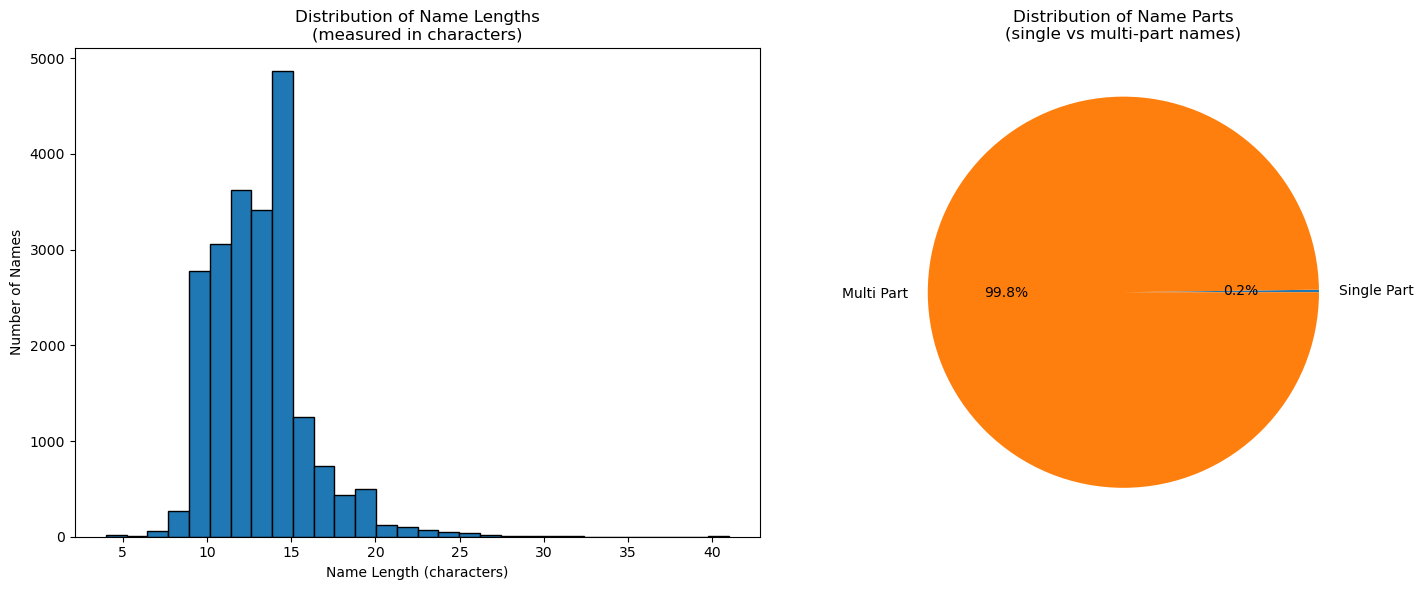

In [42]:

print("\n2. Name Statistics Analysis")
analyze_name_statistics()


3. Name Format Analysis

Name Format Analysis:

Multi Names:
Count: 1049 names
Examples:
  - Lola Myrtle Roberson
  - Ella Ruth Chamblee

Initial Names:
Count: 375 names
Examples:
  - L. E. Hannah
  - B. B. Mattox

Two Names:
Count: 20030 names
Examples:
  - Billy Williams
  - Alpha Black

Titled Names:
Count: 29 names
Examples:
  - Revy Williamson
  - Reves Brothers


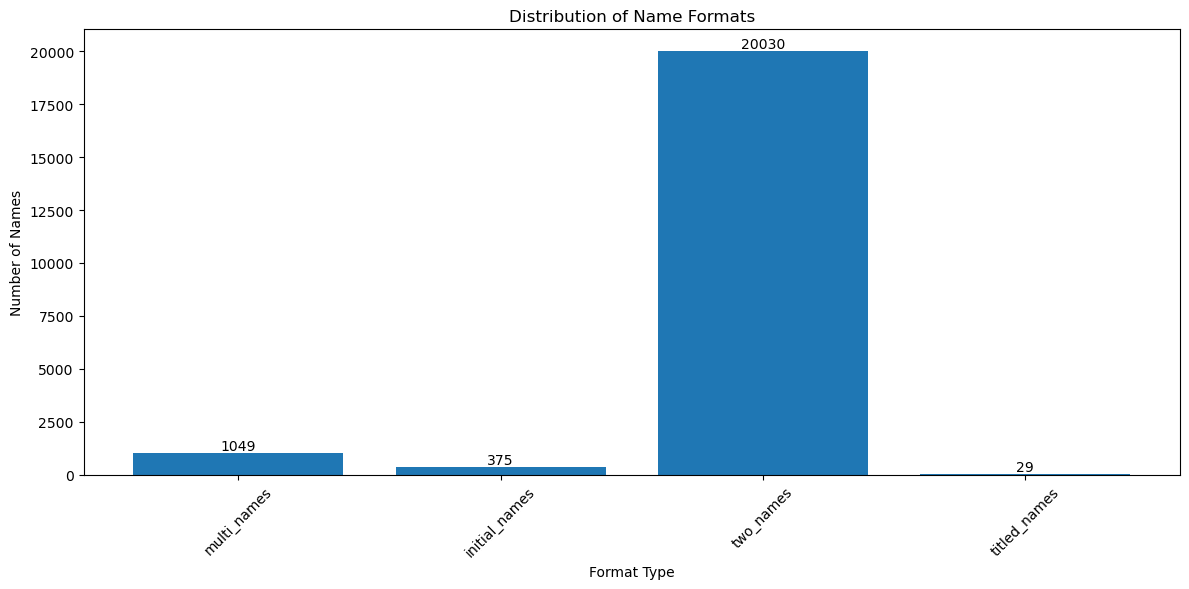

In [43]:


print("\n3. Name Format Analysis")
analyze_name_formats()


Title Frequencies and Sample Names:
Brother: 9 occurrences
  Sample names:
    - Brother Ronald Gilmore
    - Brother Marlon Wilkerson

Sister: 6 occurrences
  Sample names:
    - Sister Susan Karina Dickey
    - Sister Susan

Miss: 3 occurrences
  Sample names:
    - Miss Ruth
    - Miss Hester Edwards

Judge: 2 occurrences
  Sample names:
    - Judge Donald Ross
    - Judge Otis Knippers

Captain: 2 occurrences
  Sample names:
    - Captain Kidd
    - Captain Robert Carl Hobson

Father: 1 occurrences
  Sample names:
    - Father Ronald Baker
    - Rev Harold Tyson

Rev: 1 occurrences
  Sample names:
    - Father Ronald Baker
    - Rev Harold Tyson



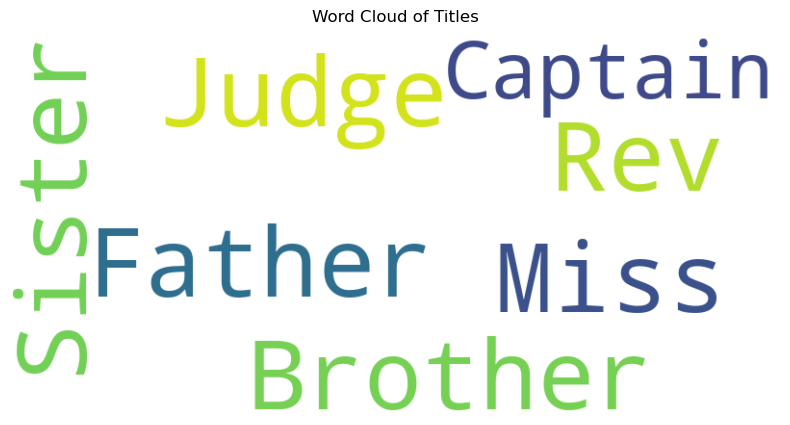

In [44]:
def generate_title_wordcloud():
    """Generate a wordcloud of titles from the leaders table."""
    conn = sqlite3.connect('minutes.db')
    
    # Get all names
    query = "SELECT name FROM leaders"
    df = pd.read_sql_query(query, conn)
    
    if len(df) == 0:
        print("No data found in leaders table")
        return
    
    # Common titles and their variations - only actual titles, not initials
    # Using word boundary patterns to ensure we match complete words
    title_patterns = {
        'Rev': [r'\bRev\b', r'\bReverend\b', r'\bPastor\b', r'\bFather\b'],
        'Mr': [r'\bMr\b', r'\bMister\b'],
        'Mrs': [r'\bMrs\b', r'\bMissus\b'],
        'Ms': [r'\bMs\b', r'\bMiss\b'],
        'Dr': [r'\bDr\b', r'\bDoctor\b', r'\bProf\b', r'\bProfessor\b', r'\bPhD\b', r'\bPh\.D\b'],
        'Military': [r'\bColonel\b', r'\bCaptain\b', r'\bMajor\b', r'\bGeneral\b'],
        'Professional': [r'\bJudge\b', r'\bAttorney\b', r'\bLawyer\b', r'\bEsq\b', r'\bEsquire\b'],
        'Brother': [r'\bBrother\b'],
        'Sister': [r'\bSister\b']
    }
    
    # Initialize title text list and sample names
    title_text = []
    title_samples = {title: [] for title in title_patterns.keys()}
    
    # Analyze each name
    for name in df['name']:
        if not name:
            continue
        
        # Check for title matches using regex
        for title, patterns in title_patterns.items():
            for pattern in patterns:
                match = re.search(pattern, name)
                if match:
                    actual_title = match.group(0)
                    title_text.append(actual_title)
                    # Store sample name if we don't have enough yet
                    if len(title_samples[title]) < 2 and name not in title_samples[title]:
                        title_samples[title].append(name)
                    break
    
    # Generate wordcloud of titles
    if title_text:
        # Create text for wordcloud - repeat each title based on its frequency
        title_freq = {}
        for title in title_text:
            if title in title_freq:
                title_freq[title] += 1
            else:
                title_freq[title] = 1
        
        # Print title frequencies and samples
        print("\nTitle Frequencies and Sample Names:")
        print("=" * 50)
        for title, freq in sorted(title_freq.items(), key=lambda x: x[1], reverse=True):
            print(f"{title}: {freq} occurrences")
            # Find which category this title belongs to
            for category, patterns in title_patterns.items():
                if any(re.search(pattern, title) for pattern in patterns):
                    if title_samples[category]:  # Only print if we have samples
                        print("  Sample names:")
                        for sample in title_samples[category]:
                            print(f"    - {sample}")
                    print()
                    break
        
        # Create text with titles repeated based on frequency
        text = ' '.join([title + ' ' * (freq-1) for title, freq in title_freq.items()])
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=100,
            contour_width=3,
            contour_color='steelblue',
            min_font_size=10,
            max_font_size=100
        ).generate(text)
        
        # Display wordcloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Titles')
        plt.show()
    else:
        print("No titles found in the data")
    
    conn.close()

# Run the analysis
generate_title_wordcloud()

## Alias Pattern Analysis


Alias Statistics and Examples:

1. Total Aliases: 2244
Sample examples:
   - Original: Duane Nasis → Alias: Duane Nassis
   - Original: Kathy Collett → Alias: Katherine Collett
   - Original: Jesse P. Karlsberg → Alias: Jeff Carlsberg

2. Average Name Lengths:
   Original names: 14.10 characters
   Alias names: 14.13 characters
Sample examples of different lengths:
   - Original: Ella Ruth Chamblee (18 chars)
     Alias: Ruth Chamblee (13 chars)
     Difference: -5 chars
   - Original: James Robert Chambless (22 chars)
     Alias: Robert Chambliss (16 chars)
     Difference: -6 chars
   - Original: Sadhbh O’Flynn (14 chars)
     Alias: Sadhbh Ni Fhloinn (17 chars)
     Difference: 3 chars

3. Average Length Difference: 0.04 characters
Sample examples of similar lengths:
   - Original: Jacqui Selby-MacLeod (20 chars)
     Alias: Jacqui Selby- MacLeod (21 chars)
   - Original: Carol Huang (11 chars)
     Alias: Carol Juang (11 chars)
   - Original: Miranel Swafford (16 chars)
     Alias

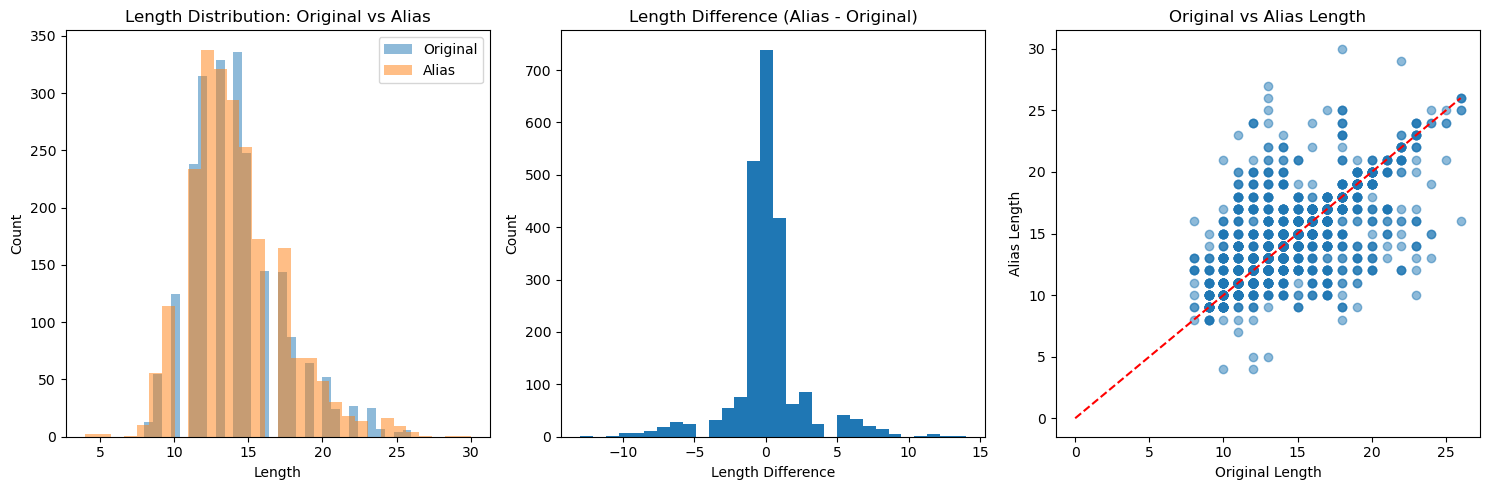

In [45]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def analyze_alias_patterns():
    """Analyze patterns in name aliases with sample examples."""
    conn = sqlite3.connect('minutes.db')
    
    # Query for alias analysis
    query = """
    SELECT 
        l.name as original_name,
        a.alias,
        LENGTH(l.name) as original_length,
        LENGTH(a.alias) as alias_length,
        (LENGTH(a.alias) - LENGTH(l.name)) as length_diff
    FROM leaders l
    JOIN leader_name_aliases a ON l.id = a.leader_id
    """
    df = pd.read_sql_query(query, conn)
    
    # Alias statistics
    stats = {
        'total_aliases': len(df),
        'avg_original_length': df['original_length'].mean(),
        'avg_alias_length': df['alias_length'].mean(),
        'length_diff': (df['alias_length'] - df['original_length']).mean()
    }
    
    # Display statistics with examples
    print("\nAlias Statistics and Examples:")
    print("=" * 50)
    
    # 1. Total Aliases
    print(f"\n1. Total Aliases: {stats['total_aliases']}")
    print("Sample examples:")
    sample_aliases = df.sample(min(3, len(df)))
    for _, row in sample_aliases.iterrows():
        print(f"   - Original: {row['original_name']} → Alias: {row['alias']}")
    
    # 2. Average Lengths
    print(f"\n2. Average Name Lengths:")
    print(f"   Original names: {stats['avg_original_length']:.2f} characters")
    print(f"   Alias names: {stats['avg_alias_length']:.2f} characters")
    print("Sample examples of different lengths:")
    # Show examples where lengths differ significantly
    length_diff_examples = df[abs(df['length_diff']) > 2].sample(min(3, len(df)))
    for _, row in length_diff_examples.iterrows():
        print(f"   - Original: {row['original_name']} ({row['original_length']} chars)")
        print(f"     Alias: {row['alias']} ({row['alias_length']} chars)")
        print(f"     Difference: {row['length_diff']} chars")
    
    # 3. Length Difference
    print(f"\n3. Average Length Difference: {stats['length_diff']:.2f} characters")
    print("Sample examples of similar lengths:")
    # Show examples where lengths are similar
    similar_length_examples = df[abs(df['length_diff']) <= 1].sample(min(3, len(df)))
    for _, row in similar_length_examples.iterrows():
        print(f"   - Original: {row['original_name']} ({row['original_length']} chars)")
        print(f"     Alias: {row['alias']} ({row['alias_length']} chars)")
    
    # Visualize alias patterns
    plt.figure(figsize=(15, 5))
    
    # Length comparison
    plt.subplot(1, 3, 1)
    plt.hist(df['original_length'], bins=30, alpha=0.5, label='Original')
    plt.hist(df['alias_length'], bins=30, alpha=0.5, label='Alias')
    plt.title('Length Distribution: Original vs Alias')
    plt.xlabel('Length')
    plt.ylabel('Count')
    plt.legend()
    
    # Length difference
    plt.subplot(1, 3, 2)
    plt.hist(df['length_diff'], bins=30)
    plt.title('Length Difference (Alias - Original)')
    plt.xlabel('Length Difference')
    plt.ylabel('Count')
    
    # Scatter plot of original vs alias length
    plt.subplot(1, 3, 3)
    plt.scatter(df['original_length'], df['alias_length'], alpha=0.5)
    plt.plot([0, max(df['original_length'])], [0, max(df['original_length'])], 'r--')
    plt.title('Original vs Alias Length')
    plt.xlabel('Original Length')
    plt.ylabel('Alias Length')
    
    plt.tight_layout()
    plt.show()
    
    conn.close()

if __name__ == "__main__":
    analyze_alias_patterns()

## International Characters

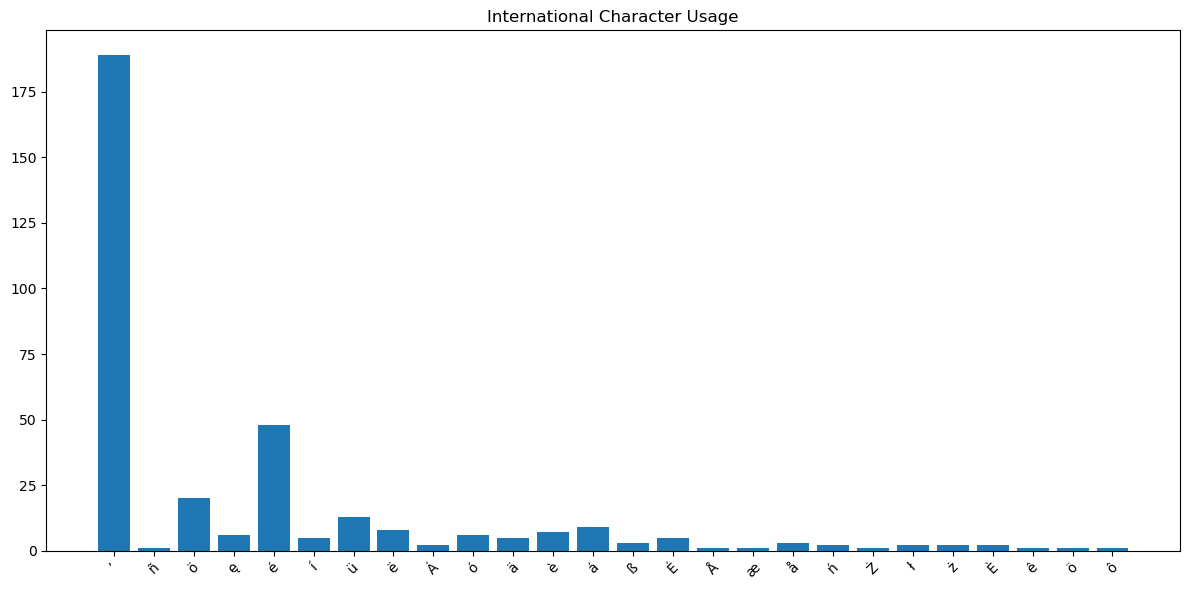


International Character Statistics:
’: 189 occurrences
ñ: 1 occurrences
ö: 20 occurrences
ę: 6 occurrences
é: 48 occurrences
í: 5 occurrences
ü: 13 occurrences
ë: 8 occurrences
Á: 2 occurrences
ó: 6 occurrences
ä: 5 occurrences
è: 7 occurrences
á: 9 occurrences
ß: 3 occurrences
É: 5 occurrences
Å: 1 occurrences
æ: 1 occurrences
å: 3 occurrences
ń: 2 occurrences
Ż: 1 occurrences
ł: 2 occurrences
ż: 2 occurrences
È: 2 occurrences
ê: 1 occurrences
ӧ: 1 occurrences
ô: 1 occurrences


In [22]:
def analyze_international_chars():
    """Analyze international character usage."""
    conn = sqlite3.connect('minutes.db')
    
    query = "SELECT name FROM leaders"
    df = pd.read_sql_query(query, conn)
    
    # Analyze international characters
    international_chars = {}
    for name in df['name']:
        for char in name:
            if ord(char) > 127:  # Non-ASCII character
                international_chars[char] = international_chars.get(char, 0) + 1
    
    if international_chars:
        # Visualize international character usage
        plt.figure(figsize=(12, 6))
        chars = list(international_chars.keys())
        counts = list(international_chars.values())
        plt.bar(range(len(chars)), counts)
        plt.title('International Character Usage')
        plt.xticks(range(len(chars)), chars, rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\nInternational Character Statistics:")
        for char, count in international_chars.items():
            print(f"{char}: {count} occurrences")
    
    conn.close()
analyze_international_chars()

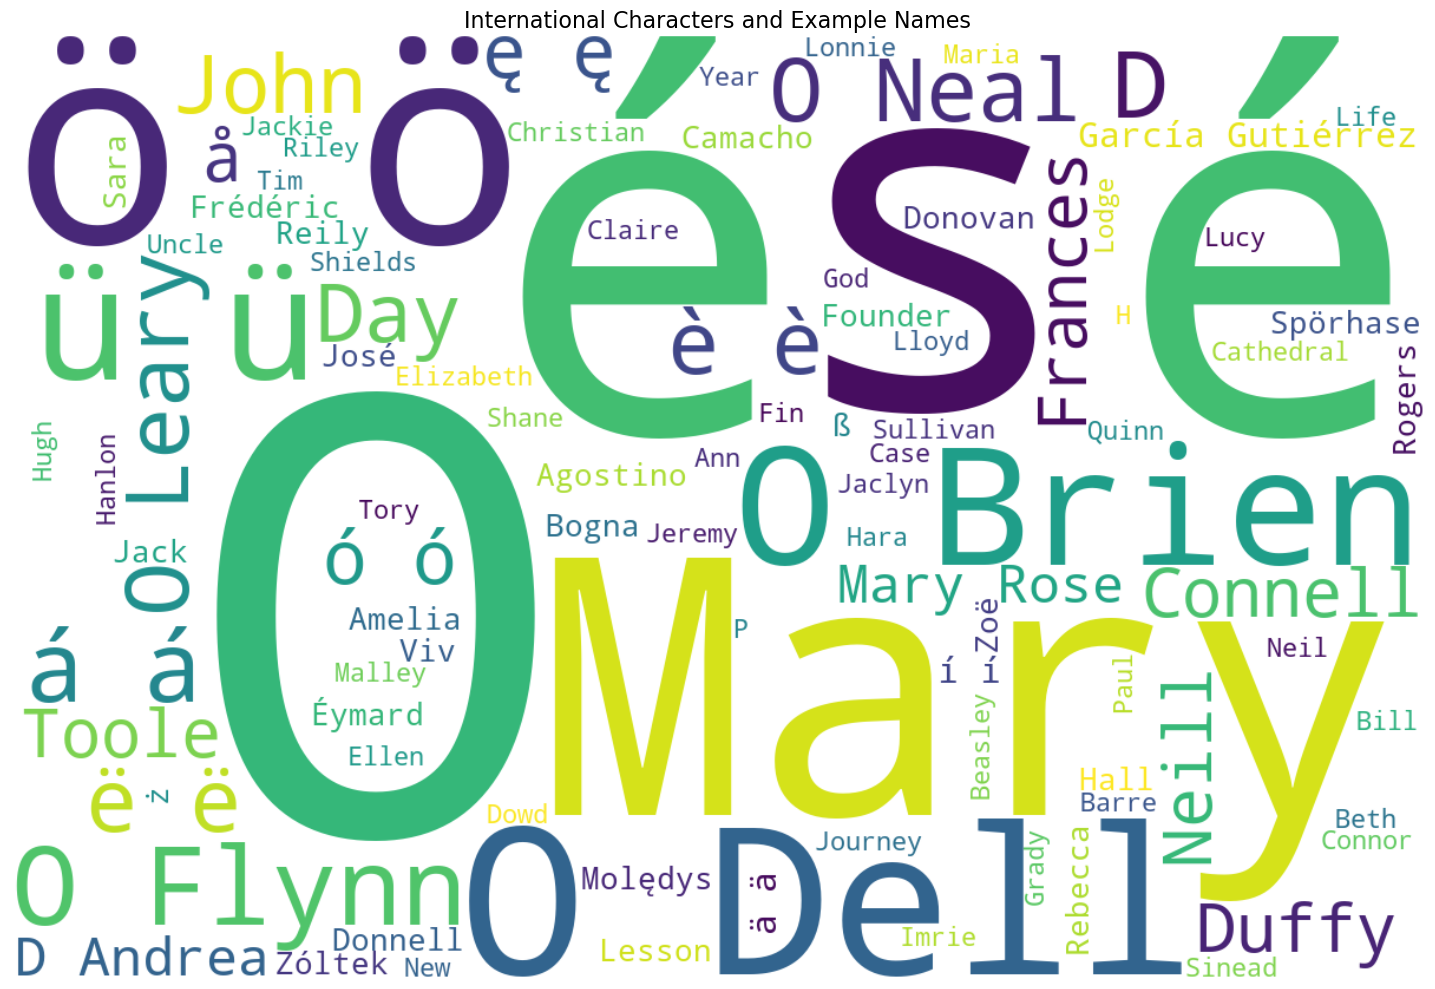


International Character Information:

Character: ’
Unicode Name: RIGHT SINGLE QUOTATION MARK
Occurrences: 189
Example Names:
  - Sinead O’Malley
  - Jarvis’s Psalm
  - Viv Imrie-O’Duffy
  - Clare O’Flynn
  - Hugh Bill’s
----------------------------------------

Character: é
Unicode Name: LATIN SMALL LETTER E WITH ACUTE
Occurrences: 48
Example Names:
  - Jéromine Eymard
  - Michele García Gutiérrez
  - Thérèse Power
  - Ellen Quenédie
  - Marie-Hélène Blondel
----------------------------------------

Character: ö
Unicode Name: LATIN SMALL LETTER O WITH DIAERESIS
Occurrences: 20
Example Names:
  - Mella Tönnies
  - Ruth Dörfler
  - Melanie Tönnies
  - Alva Fröjmark
  - Fiete Spörhase
----------------------------------------

Character: ü
Unicode Name: LATIN SMALL LETTER U WITH DIAERESIS
Occurrences: 13
Example Names:
  - Hauke Grünefeld
  - Ines Lüttgen
  - Ines Lüttger
  - Mella Tünnies
  - Rüdiger Forster
----------------------------------------

Character: á
Unicode Name: LATIN SMALL

In [23]:
def create_international_char_wordcloud():
    """Create a word cloud of names containing international characters."""
    conn = sqlite3.connect('minutes.db')
    
    query = "SELECT name FROM leaders"
    df = pd.read_sql_query(query, conn)
    
    # Dictionary to store character information
    char_info = {}
    
    # Analyze each name
    for name in df['name']:
        for char in name:
            if ord(char) > 127:  # Non-ASCII character
                if char not in char_info:
                    char_info[char] = {
                        'count': 0,
                        'unicode_name': unicodedata.name(char, 'Unknown'),
                        'examples': set()
                    }
                char_info[char]['count'] += 1
                char_info[char]['examples'].add(name)
    
    # Create text for word cloud
    wordcloud_text = ""
    for char, info in char_info.items():
        # Add the character itself with its count
        wordcloud_text += f"{char} " * info['count']
        # Add example names containing this character
        for name in info['examples']:
            wordcloud_text += f"{name} "
    
    # Create and generate the word cloud
    wordcloud = WordCloud(
        width=1200, 
        height=800,
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(wordcloud_text)
    
    # Display the word cloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('International Characters and Example Names', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print character information
    print("\nInternational Character Information:")
    print("=" * 80)
    for char, info in sorted(char_info.items(), key=lambda x: x[1]['count'], reverse=True):
        print(f"\nCharacter: {char}")
        print(f"Unicode Name: {info['unicode_name']}")
        print(f"Occurrences: {info['count']}")
        print("Example Names:")
        for name in list(info['examples'])[:5]:  # Show top 5 examples
            print(f"  - {name}")
        print("-" * 40)
    
    conn.close()

# Run the function
create_international_char_wordcloud()